This Matplotlib code is similar to a Seaborn jointplot but offers more versatility. 
Unlike Seaborn's jointplot for regression and distribution, which only provides a regression line with an intercept 
and R-squared values, this plot can be fully customized to suit various requirements.

In [1]:
import math
from matplotlib.dates import MonthLocator, YearLocator
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.odr import Model, RealData, ODR
import warnings
warnings.filterwarnings("ignore")

In [2]:
def weighted_avg_and_std(avg, values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    variance = np.average((values - avg) ** 2, weights=weights)
    return math.sqrt(variance)


In [3]:
#this function is given as a separate code in the same repository
def calculate_weighted_average_std(df, a_bins):
    x = df.col1 #assuming the predictor variable is named as col1
    y = df.col2 #assuming the target variable is named as col2
    
    std_x = [] #list to store the weighted standard deviations for x-variable
    i=0
    for i in range(len(a_bins)-1): #iterate over bins
        low = df['col1'].values>=a_bins[i] 
        high = df['col1'].values<a_bins[i+1]
        b = df.loc[(low) & (high)] #floating dataframe to select the datavalues between the given range
        ave = b['col1'].mean() #average of the bin
        c = b.groupby('col2').count() #defining weight as number of data point of y present in the bin
        c = c.reset_index()
        if b.empty: #if b in empty append 0
            zero=0
            std_x.append(zero)
        else:
            s = weighted_avg_and_std(ave,c.col2,c.col1)
            std_x.append(s)
            

    std_y = [] #list to store the weighted standard deviations for y-variable
    i=0
    for i in range(len(a_bins)-1):
        low = df['col2'].values >= a_bins[i]
        high = df['col2'].values < a_bins[i+1]
        b = df.loc[(low) & (high)]
        ave = b['col2'].mean()
        c = b.groupby('col1').count()
        c = c.reset_index()
        if b.empty:
            zero = 0
            std_y.append(zero)
        else:
            s1 = weighted_avg_and_std(ave, c.col1, c.col2)
            std_y.append(s1)
    #find the mean points for plotting
    nbins = a_bins
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    mean = sy / n
    
    x_pos = (_[1:] + _[:-1]) / 2
    plt.plot(x, y, 'bo')
    plt.errorbar((_[1:] + _[:-1]) / 2, mean, yerr=std_x, xerr=std_y, fmt='o-', color='red')
    #plt.show()
    
    return mean, std_x, std_y, x_pos

# Example usage:
# a_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
# calculate_weighted_average_std(df, a_bins)


In [4]:
#This function is given as a separate code in the same repository
def linear_regression(x, y, dx, dy):
    # TLS method
    linear_tls = Model(lambda B, a: B[0]*a)
    data_tls = RealData(x, y, sx=dx, sy=dy)
    odr_tls = ODR(data_tls, linear_tls, beta0=[1.0])
    output_tls = odr_tls.run()
    slope_tls = output_tls.beta
    err_tls = output_tls.sd_beta

    # OLS method
    degrees_x = [1]  # list of degrees of x to use
    matrix_x = np.stack([x**d for d in degrees_x], axis=-1)
    slope_ols_x, _, _, _ = np.linalg.lstsq(matrix_x, y, rcond=None)
    n_x = len(y)
    k_x = len(slope_ols_x)
    sigma2_x = np.sum((y - np.dot(matrix_x, slope_ols_x))**2) / (n_x - k_x)  # RMSE
    a_x = matrix_x.T
    C_x = sigma2_x * np.linalg.inv(np.dot(a_x, matrix_x))  # covariance matrix
    err_ols_x = np.sqrt(np.diag(C_x))  # standard error

    degrees_y = [1]  # list of degrees of y to use
    matrix_y = np.stack([y**d for d in degrees_y], axis=-1)
    slope_ols_y, _, _, _ = np.linalg.lstsq(matrix_y, x, rcond=None)
    n_y = len(x)
    k_y = len(slope_ols_y)
    sigma2_y = np.sum((x - np.dot(matrix_y, slope_ols_y))**2) / (n_y - k_y)  # RMSE
    a_y = matrix_y.T
    C_y = sigma2_y * np.linalg.inv(np.dot(a_y, matrix_y))  # covariance matrix
    err_ols_y = np.sqrt(np.diag(C_y))  # standard error

    dn = 1 / (err_tls**2) + 1 / (err_ols_x**2) + 1 / (err_ols_y**2) #denominator
    slope = (slope_tls / err_tls**2 + slope_ols_x / err_ols_x**2 + 1 / slope_ols_y / err_ols_y**2) / dn
    error = math.sqrt((abs(slope_tls - slope) / err_tls**2 + abs(slope_ols_x - slope) / err_ols_x**2 + abs(1 / slope_ols_y - slope) / err_ols_y**2) / dn)

    return slope, error


In [5]:
def plot_data(x, y, mean, std_x, std_y, a_bins, slope, error, x_pos):
    x_pos = x_pos + 0.1 #to plot the middle position
    x_pos = x_pos.astype(int)
    d = x_pos
    y1 = x_pos * slope
    y_l = x_pos * (slope + error)
    y_u = x_pos * (slope - error)
    
    #To plot the simple yearly ratios
    df["Ratio"] = df.col1/df.col2
    df['Ratio'] = df['Ratio'].replace(-np.inf, np.nan)
    df['Ratio'] = df['Ratio'].replace(np.inf, np.nan)
    df1 = df.set_index('Date').resample('Y')["Ratio"].mean()
    df1= df1.reset_index()
    df1.Date = pd.to_datetime(df1['Date'])
    
    #Define the Figure dimensions
    width_in_inches = 10
    height_in_inches = 10
    dots_per_inch = 80
    fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)
    
    #Divide the figure into 5 panels
    gs = GridSpec(5, 5)
    gs.update(wspace=0.025, hspace=0.5)
    ax_joint = fig.add_subplot(gs[1:4, 0:3])
    ax_down = fig.add_subplot(gs[4, 0:3])
    
    #Middle panel
    ax_joint.scatter(x, y, marker='o', color='green', edgecolor='lightblue', alpha=0.3, s=20)
    ax_joint.plot(d, y1, label='Slope =' + str(np.round(slope,2)) + '+-' + str(np.round(error,2)), linestyle='--')
    ax_joint.legend()
    ax_joint.fill_between(d, y_u, y_l, color='lightblue', alpha=0.5)
    ax_joint.errorbar(d, mean, yerr=std_x, xerr=std_y, fmt='o', color='black', capthick=3, elinewidth=2, capsize=3, alpha=0.5)
    
    #Locate axes and other details
    divider = make_axes_locatable(ax_joint)
    ax_joint.set_xlim(0, 13)
    ax_joint.grid()
    ax_joint.set_ylabel('Col2', fontsize=18)
    
    #set the upper and side panels
    ax_marg_x = divider.append_axes("top", 0.5, sharex=ax_joint)
    ax_marg_y = divider.append_axes("right", 0.6, sharey=ax_joint)
    
    #histograms: 1st line is for right panel, 2nd line is for upper panel
    n1, x1, _ = ax_marg_y.hist(y, orientation="horizontal", facecolor='lightblue', alpha=0.3, edgecolor='blue', bins=a_bins)
    b,a,_ =ax_marg_x.hist(x,facecolor='green',alpha=0.3,edgecolor='red',bins=a_bins)
    ax_marg_x.grid()
    bin_centers = 0.5 * (a[1:] + a[:-1])
    ax_marg_x.plot(bin_centers, b, color='blue') # locate the bin centres to plot a smooth line
    
    #make the borders visisble or invisisble for upper panel
    ax_marg_x.spines['top'].set_visible(False)
    ax_marg_x.spines['right'].set_visible(False)
    ax_marg_x.spines['left'].set_visible(False)
    
    #make the borders visible or invisible for right panel
    bin_centers1 = 0.5 * (x1[1:] + x1[:-1])
    base = plt.gca().transData
    ax_marg_y.plot(n1, bin_centers1, color='green')
    ax_marg_y.grid()
    ax_marg_y.spines['top'].set_visible(False)
    ax_marg_y.spines['right'].set_visible(False)
    ax_marg_y.spines['left'].set_visible(False)

    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    
    #The lower panel
    ax_down.plot(df1['Date'], df1['Ratio'], color='black')
    ax_down.set_xlabel('Col1', fontsize=18)
    ax_down.locator_params(axis='y')
    ax_down.spines['top'].set_visible(False)
    ax_down.spines['right'].set_visible(False)
    ax_down.spines['left'].set_visible(False)
    ax_down.grid()
    plt.gcf().subplots_adjust(bottom=0.35)
    plt.show()


In [6]:
df = pd.read_csv(r'C:\Users\ShreyaB\Documents\Mitteilungen\data\weighted_average_example.csv')
df.Date = pd.to_datetime(df.Date)

In [7]:
df.head()

,Date,col1,col2
0,1854-02-04,3,3
1,1854-03-17,2,2
2,1854-09-12,3,3
3,1855-10-20,2,2
4,1857-01-14,3,3


In [8]:
x= df.col1
y= df.col2

In [9]:
df["dx"] = x.std()
df["dy"] = y.std()

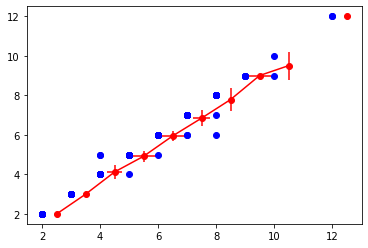

In [10]:
a_bins = [1, 2, 3.,  4.,  5.,6,7,8,9,10,11,12,13]
mean, std_x, std_y, x_pos = calculate_weighted_average_std(df, a_bins)


In [11]:
slope, error = linear_regression(x, y, df.dx, df.dy)

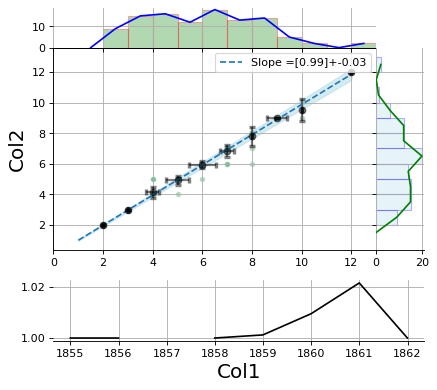

In [12]:
plot_data(x, y, mean, std_x, std_y, a_bins, slope, error, x_pos)